In [6]:
#Importing libraries
import azureml.core
from azureml.core import Workspace, Dataset
from azureml.core import Experiment
from azureml.widgets import RunDetails
from azureml.core import Run
from azureml.core import Experiment, ScriptRunConfig, Environment
from azureml.core.runconfig import DockerConfiguration
from azureml.widgets import RunDetails
import mlflow

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [30]:
#Creating the workspace
ws = Workspace.from_config()

#Linkg workspace with mlflow
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())


In [8]:
dataset = Dataset.get_by_name(ws, name='AirlinesDelay')
#df = dataset.to_pandas_dataframe()

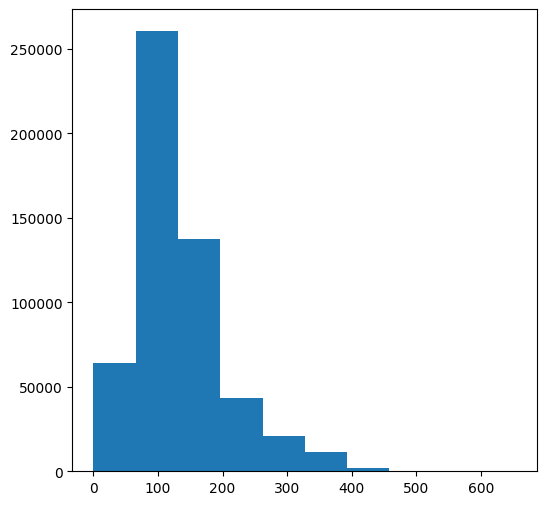

Plot listo!


In [25]:
#%%writefile experiments/mlflow_eda.py

from funct.myfuncs import cln_data
import argparse

experiment_name ='exp-Airlines'
mlflow.set_experiment(experiment_name)

with mlflow.start_run() as run:
    
    #loading data 
    #dataset = Dataset.get_by_name(ws, name='AirlinesDelay')
    df = pd.read_csv("../airlines_delay/airlines_delay.csv", sep = ",")
    
    #Distribution of the target column
    class_cero, class_one = df['Class'].value_counts()
    mlflow.log_metrics({'one':class_one, 'cero':class_cero})
    
    #Comparation of the mean
    mean_comparison = df[['Time','Length', 'Class']].groupby('Class').mean().to_dict()
 
    mlflow.log_metrics({'Mean Time class cero':mean_comparison['Time'][0], 'Mean Time class one':mean_comparison['Time'][1]})
    mlflow.log_metrics({'Mean Lenght class cero':mean_comparison['Length'][0], 'Mean Length class one':mean_comparison['Length'][1]})

    #Number of airlines
    number_of_airlines = len(df['Airline'].unique())

    mlflow.log_metric('number of airlines', number_of_airlines)

    #flights per airlnes
    flights_per_airline = df['Airline'].value_counts().to_dict()
    mlflow.log_metrics(flights_per_airline)

    
    #airports
    number_of_airports = len(df['AirportFrom'].unique())
    mlflow.log_metric('number of airports', number_of_airports)

    #airports with more activity
    arports_activity_df = df['AirportFrom'].value_counts().sort_values(ascending=False) + df['AirportTo'].value_counts().sort_values(ascending=False)
    top_5_airpots_activity = arports_activity_df.sort_values(ascending=False).head(5).to_dict()

    top_and_lowest_ariports_activity = {}
    for k, _ in top_5_airpots_activity.items():
        top_and_lowest_ariports_activity[f'Airport {k}'] = top_5_airpots_activity[k]


    #airports with more activity
    lowest_5_airpots_activity = arports_activity_df.sort_values(ascending=False).tail(5).to_dict()
    for k, _ in lowest_5_airpots_activity.items():
        top_and_lowest_ariports_activity[f'Airport {k}'] = lowest_5_airpots_activity[k]

    mlflow.log_metrics(top_and_lowest_ariports_activity)

    #DaysWeek
    dict_day_of_week= {1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday', 7: 'Sunday'}
    df_day_of_week = df.replace({"DayOfWeek": dict_day_of_week},inplace=False)
    fligths_per_day_of_week = df_day_of_week['DayOfWeek'].value_counts().to_dict()

    mlflow.log_metrics(fligths_per_day_of_week)


    #plot distribution of time
    fig = plt.figure(figsize=(6,6))
    ax = fig.gca()    
    plt.hist(df['Length'])
    plt.show()
    mlflow.log_figure(fig, "plot.png")
    print("Plot listo!")


In [19]:
df = pd.read_csv("../airlines_delay/airlines_delay.csv", sep = ",")

df.head()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0
3,31.0,1410.0,344.0,US,OGG,PHX,6,0
4,563.0,692.0,98.0,FL,BMI,ATL,4,0


In [37]:
#Correlación entre variables
df[['Time', 'Length', 'Class']].corr().to_dict()

{'Time': {'Time': 1.0,
  'Length': -0.020609903703868126,
  'Class': 0.15045680780283274},
 'Length': {'Time': -0.020609903703868126,
  'Length': 1.0,
  'Class': 0.04048828550051612},
 'Class': {'Time': 0.15045680780283274,
  'Length': 0.04048828550051612,
  'Class': 1.0}}

In [14]:
# Ambiente para el experimento
env = Environment.from_conda_specification("env_exploratorio", "./env/environment.yml")

script_mlflow = ScriptRunConfig(source_directory='./experiments/',
                                script='mlflow_eda.py',
                                environment=env,
                                docker_runtime_config=DockerConfiguration(use_docker=True)) 

# submit the experiment
experiment = Experiment(workspace=ws, name='exp-prueba')

run = experiment.submit(config=script_mlflow)
run.wait_for_completion()


No Python version provided, defaulting to "3.8.13"


In [5]:
mlflow.end_run()

## Preprocessing

In [86]:
##%%writefile experiments/mlflow_preprocess.py
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import numpy as np
import pandas as pd

df = pd.read_csv("../airlines_delay/airlines_delay.csv", sep = ",")

def clean_data(data:pd.DataFrame) -> pd.DataFrame:
    '''
    Delete the Fligh column
    input: dataset
    output: pandas dataframe withiout Flight
    '''
    clean_df = data.drop('Flight', axis=1, inplace=False)
    return clean_df


def preprocess_data(data:pd.DataFrame) -> pd.DataFrame:
    '''
    Preprocess the data converting the categorical columns to one hot encodig
    and apply standarScaler to numeric columns
    input: pandas dataFrame
    output: tuple, first element corrempond to pd.Dataframe of independent features
            second element is the dependent(target) feature 
    '''

    numeric_columns = ['Length','Time']
    category_columns = ['Airline', 'AirportFrom', 'AirportTo', 'DayOfWeek']

    numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                            ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))])

    preprocessor = ColumnTransformer(
                        transformers=[
                            ('numeric', numeric_transformer, numeric_columns),
                            ('cat', categorical_transformer, category_columns)
                        ],
                        remainder='passthrough'
                    )
    
    #split the dependent(y) and independent(df_x) features 
    df_X = data.drop('Class', axis=1, inplace=False)
    #y_labels = data['Class']
    y = data['Class']
    preprocessed_data = preprocessor.fit_transform(df_X)
    encoded_category = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(category_columns)

    labels = np.concatenate([numeric_columns, encoded_category])
    
    preprocessed_df = pd.DataFrame(data=preprocessed_data, columns=labels)
    return pd.concat([preprocessed_df, y], axis=1)



df_new = clean_data(df)
processed_df= preprocess_data(df_new)
processed_df.head()

#df_new.head()

,Length,Time,Airline_AA,Airline_AS,Airline_B6,Airline_CO,Airline_DL,Airline_EV,Airline_F9,Airline_FL,...,AirportTo_XNA,AirportTo_YAK,AirportTo_YUM,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,Class
0,0.125475,1.774070,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.196784,-1.592288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,0.153998,1.320907,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
3,3.020636,2.184075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,-0.487786,-0.398238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0


In [83]:
df.head()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0
3,31.0,1410.0,344.0,US,OGG,PHX,6,0
4,563.0,692.0,98.0,FL,BMI,ATL,4,0


In [28]:
%%writefile experiments/mlflow_preprocess.py

from funct.myfuncs import cln_data, preprocs_data

from sklearn.model_selection import train_test_split

experiment_name ='exp-Airlines'
mlflow.set_experiment(experiment_name)

with mlflow.start_run() as run:
    
    #loading data 
    #dataset = Dataset.get_by_name(ws, name='AirlinesDelay')
    df = pd.read_csv("../airlines_delay/airlines_delay.csv", sep = ",")

    df_clean= cln_data(df)

    train, test, = train_test_split(df_clean, test_size=0.3, random_state=73)
    
    train.to_csv('airlines_train.csv')
    test.to_csv('airlines_test.csv')

    mlflow.log_artifact('airlines_train.csv')
    mlflow.log_artifact('airlines_test.csv')

    x_train = train.drop('Class', axis=1, inplace=False)
    y_train = train['Class']
    
    preprocess_data_x = preprocs_data(x_train)

    preprocess_data_x.to_csv('airlines_train_processed.csv')
    mlflow.log_artifact('airlines_train_processed.csv')

Writing experiments/mlflow_preprocess.py


In [20]:
stroke_ds = ws.datasets.get("AirlinesDelay")
stroke_ds.as_named_input('raw_data')

In [26]:
from azureml.pipeline.steps import PythonScriptStep
from azureml.pipeline.core import Pipeline
experiment_folder = './experiments/'
exploratory_step = PythonScriptStep(name = "Exploratory Data",
                               source_directory = experiment_folder,
                               script_name = "mlflow_eda.py",
                               arguments = ['--input-data', stroke_ds.as_named_input('raw_data')],
                               #compute_target = instance,
                               #runconfig = pipeline_run_config,
                               allow_reuse = True)

## Subir los datos a Azure Blob

In [ ]:
from azureml.core import Workspace

airlines_delay = '../airlines_delay/airlines_delay.csv'

ws = Workspace.from_config()

# Default datastore
default_store = ws.get_default_datastore() 

default_store.upload_files([airlines_delay], 
                           target_path = 'airlines', 
                           overwrite = True, 
                           show_progress = True)

print("Upload calls completed.")

## Crear y registrar datasets

In [1]:
from azureml.core import Dataset, Datastore
from azureml.core import Workspace

airlines_delay = '../airlines_delay/airlines_delay.csv'

ws = Workspace.from_config()

# Default datastore
default_store = ws.get_default_datastore() 
# Al crear un conjunto de datos, crea una referencia a la ubicación de la fuente de datos. 
# Si aplicó transformaciones de subconjuntos al conjunto de datos, también se almacenarán en el conjunto de datos. 
# Los datos permanecen en su ubicación actual, por lo que no se incurre en ningún costo adicional de almacenamiento.
airlines_delay_data = Dataset.Tabular.from_delimited_files(default_store.path('UI/2023-03-07_192934_UTC/airlines_delay.csv'))

# Registrar los conjuntos de datos con el workspace de trabajo para que pueda reutilizarlos en otros experimentos
#  o compartirlos.

#airlines_delay_data = airlines_delay_data.register(ws, 'airlines_delay_data')

## Setup compute

In [2]:
from azureml.core.compute import ComputeTarget, ComputeInstance
from azureml.core.compute_target import ComputeTargetException

# nombre del cluster
compute_name = "prueba-DS"

# verificación de exixtencia del cluster
try:
    aml_compute = ComputeTarget(workspace=ws, name=compute_name)
    print('Existe!')
except ComputeTargetException:
    
    compute_config = ComputeInstance.provisioning_configuration(vm_size='Standard_DS11_v2',
                                                           ssh_public_access=False)
    aml_compute = ComputeTarget.create(ws, compute_name, compute_config)

aml_compute.wait_for_completion(show_output=True)

Existe!

Running


## Definir el ambiente de trabajo

In [7]:
from azureml.core.runconfig import RunConfiguration
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core import Experiment, ScriptRunConfig, Environment
# Create a Python environment for the experiment (from a .yml file)
experiment_env = Environment.from_conda_specification("experiment_env",  './env/environment.yml')

# Register the environment 
experiment_env.register(workspace=ws)
registered_env = Environment.get(ws, 'experiment_env')

# Create a new runconfig object for the pipeline
pipeline_run_config = RunConfiguration()

# Use the compute you created above. 
pipeline_run_config.target = aml_compute

# Assign the environment to the run configuration
pipeline_run_config.environment = registered_env

The best practice is to use separate folders for scripts and its dependent files for each step and specify that folder as the source_directory for the step. This helps reduce the size of the snapshot created for the step (only the specific folder is snapshotted). Since changes in any files in the source_directory would trigger a re-upload of the snapshot, this helps keep the reuse of the step when there are no changes in the source_directory of the step.

In [ ]:
# preprocesamiento
#1. eliminar columna que no importa
#2. cambiar variables categoricas en numericas
#3. Estandarizar variables numericas
#4. split resultados

## Limpieza de los datos

In [9]:
from azureml.pipeline.core import PipelineData
from azureml.pipeline.steps import PythonScriptStep
import mlflow
#Linkg workspace with mlflow
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())


#https://learn.microsoft.com/en-us/python/api/azureml-pipeline-core/azureml.pipeline.core.pipelinedata?view=azure-ml-py
clean_airlines_data = PipelineData("clean_airlines_data", datastore=default_store, is_directory=True).as_dataset()

clean_step = PythonScriptStep(
    name="Clean airlines data",
    script_name="data_clean.py", 
    arguments=["--output_cleanse", clean_airlines_data],
    inputs=[airlines_delay_data.as_named_input('raw_data')],
    outputs=[clean_airlines_data],
    compute_target=aml_compute,
    runconfig=pipeline_run_config,
    source_directory='./scripts/',
    allow_reuse=True
)

print("Done.")

transformed_data = PipelineData('transformed_data', datastore=default_store, is_directory=True)

transform_step = PythonScriptStep(
    name="transform airlines data",
    script_name="data_transform.py", 
    arguments=["--output_transform", transformed_data],
    inputs=[clean_airlines_data.parse_delimited_files()],
    outputs=[transformed_data],
    compute_target=aml_compute,
    runconfig=pipeline_run_config,
    source_directory='./scripts/',
    allow_reuse=True
)


Done.


In [10]:
from azureml.core import Experiment
from azureml.pipeline.core import Pipeline
from azureml.widgets import RunDetails

# Construct the pipeline
pipeline_steps = [clean_step, transform_step]
pipeline = Pipeline(workspace=ws, steps=pipeline_steps)
print("Pipeline is built.")


# Create an experiment and run the pipeline
experiment = Experiment(workspace=ws, name = 'exp-Airlines')
pipeline_run = experiment.submit(pipeline, regenerate_outputs=True)
print("Pipeline submitted for execution.")
RunDetails(pipeline_run).show()
pipeline_run.wait_for_completion(show_output=True)

Pipeline is built.
Created step Clean airlines data [5191ad0e][5914b374-bf2c-464a-8a9c-eb2d24455c56], (This step will run and generate new outputs)
Created step transform airlines data [fd87b359][4a37627e-70f5-4844-b99a-6314094a6346], (This step will run and generate new outputs)
Submitted PipelineRun 13ae0c9f-edce-45a2-a859-ac8a48cd7678
Link to Azure Machine Learning Portal: https://ml.azure.com/runs/13ae0c9f-edce-45a2-a859-ac8a48cd7678?wsid=/subscriptions/20d4fdf3-6a4b-4f0b-a842-bd7392136332/resourcegroups/cienciadatos/workspaces/azureml&tid=c7db5234-eb19-42fd-8840-a85829ea4628
Pipeline submitted for execution.


_PipelineWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', …

PipelineRunId: 13ae0c9f-edce-45a2-a859-ac8a48cd7678
Link to Azure Machine Learning Portal: https://ml.azure.com/runs/13ae0c9f-edce-45a2-a859-ac8a48cd7678?wsid=/subscriptions/20d4fdf3-6a4b-4f0b-a842-bd7392136332/resourcegroups/cienciadatos/workspaces/azureml&tid=c7db5234-eb19-42fd-8840-a85829ea4628
PipelineRun Status: Running


StepRunId: 80c5c174-6fd0-4b67-a64e-5387173a98e4
Link to Azure Machine Learning Portal: https://ml.azure.com/runs/80c5c174-6fd0-4b67-a64e-5387173a98e4?wsid=/subscriptions/20d4fdf3-6a4b-4f0b-a842-bd7392136332/resourcegroups/cienciadatos/workspaces/azureml&tid=c7db5234-eb19-42fd-8840-a85829ea4628
StepRun( Clean airlines data ) Status: NotStarted
StepRun( Clean airlines data ) Status: Running

StepRun(Clean airlines data) Execution Summary
StepRun( Clean airlines data ) Status: Finished
{'runId': '80c5c174-6fd0-4b67-a64e-5387173a98e4', 'target': 'prueba-DS', 'status': 'Completed', 'startTimeUtc': '2023-03-15T00:51:46.31211Z', 'endTimeUtc': '2023-03-15T00:52:13.879138

'Finished'